In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L2

from dataloader_v1 import SpectDataset

In [2]:
tf.__version__

'2.7.0'

In [3]:
seed = 123
tf.random.set_seed(seed)

In [4]:
DATA_PATH = '../../data/spcup_2022_training_part1'
Labeled_dir = '../../data/final_labels.csv'

In [5]:
dataloader = SpectDataset(add_noise=True)
train_ds, val_ds = dataloader.call(DATA_PATH, Labeled_dir)

In [6]:
def SBCNN_Model(input_shape, num_labels):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(24, 5, padding='same'))
    model.add(MaxPool2D(strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, 5, padding='same'))
    model.add(MaxPool2D(strides=(4, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, 5, padding='valid'))
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_regularizer=L2(0.001)))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, kernel_regularizer=L2(0.001)))
    model.add(Activation('softmax'))

    return model

In [7]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (32, 124, 129, 1)


In [8]:
model = SBCNN_Model(input_shape[1:], 6)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [10]:
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
150/150 [==============================] - 18s 54ms/step - loss: 1.8380 - accuracy: 0.2681 - val_loss: 1.5268 - val_accuracy: 0.4483
Epoch 2/15
150/150 [==============================] - 6s 37ms/step - loss: 1.4460 - accuracy: 0.4640 - val_loss: 1.0854 - val_accuracy: 0.6350
Epoch 3/15
150/150 [==============================] - 6s 37ms/step - loss: 1.2339 - accuracy: 0.5371 - val_loss: 1.0253 - val_accuracy: 0.6658
Epoch 4/15
150/150 [==============================] - 6s 37ms/step - loss: 1.1120 - accuracy: 0.5908 - val_loss: 0.9172 - val_accuracy: 0.6958
Epoch 5/15
150/150 [==============================] - 6s 37ms/step - loss: 1.0491 - accuracy: 0.6212 - val_loss: 0.8712 - val_accuracy: 0.7142
Epoch 6/15
150/150 [==============================] - 6s 37ms/step - loss: 0.9906 - accuracy: 0.6404 - val_loss: 0.8321 - val_accuracy: 0.7258
Epoch 7/15
150/150 [==============================] - 6s 37ms/step - loss: 0.9413 - accuracy: 0.6590 - val_loss: 0.8092 - val_accuracy: 0.721

__Model training visualization__

In [11]:
import matplotlib.pyplot as plt

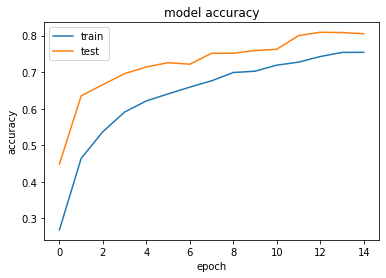

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

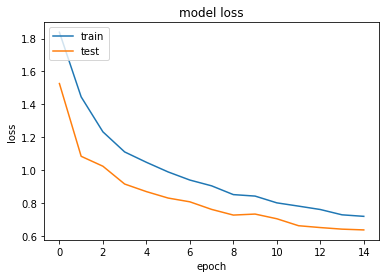

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Sample Evaluation pipeline building__

_extracting y_pred and y_true values_

In [14]:
import numpy as np

In [15]:
res_sparse = model.predict(val_ds)

In [16]:
res_np = np.argmax(res_sparse, axis=1)
pred_labels = list(res_np)

In [17]:
true_labels = []
for _, label in val_ds.take(1000):
    true_labels.extend(list(label.numpy()))

In [18]:
from sklearn.metrics import classification_report

_class-wise analysis_

In [24]:
class_names = [f'class_{i}' for i in range(6)]
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

     class_0       0.99      0.97      0.98       200
     class_1       0.56      0.87      0.69       200
     class_2       0.75      0.60      0.66       200
     class_3       0.85      0.94      0.89       200
     class_4       0.99      0.99      0.99       200
     class_5       0.81      0.47      0.59       200

    accuracy                           0.81      1200
   macro avg       0.82      0.81      0.80      1200
weighted avg       0.82      0.81      0.80      1200



_confusion metrics_

In [25]:
import matplotlib.pyplot as plt
import itertools

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
from sklearn import metrics

Confusion matrix, without normalization


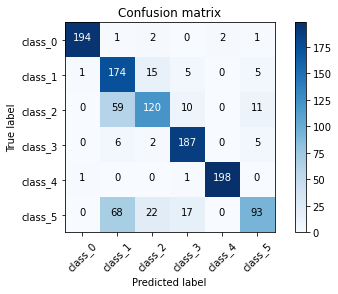

In [28]:
cm = metrics.confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(cm, classes=class_names)


_overall analysis_

_Jaccard metrics_

In [46]:
# Jaccard metrics - macro
from sklearn.metrics import jaccard_score
jaccard_score(true_labels, pred_labels, average='macro')

0.8335006243586051

In [47]:
# F1 - macro
from sklearn.metrics import f1_score
f1_score(true_labels, pred_labels, average='macro')

0.9024746084163053

In [48]:
# precision - macro
from sklearn.metrics import precision_score
precision_score(true_labels, pred_labels, average='macro')

0.9032256751795185

In [49]:
# recall - macro
from sklearn.metrics import recall_score
recall_score(true_labels, pred_labels, average='macro')

0.9029999999999999

In [50]:
# Cohen's Kappa metrics
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(true_labels, pred_labels)

0.87875

In [51]:
# matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(true_labels, pred_labels)

0.8790742184068319

__Model result interoperability__